## Practical 8: Working with Text

The basics of Text Mining and NLP

A lot of the content here is provided to help you *understand* what
text-cleaning does and how it generates tokens that can be processed by
the various analytical approaches commonly-used in NLP. The best way to
think about this is as a practical in two parts, with a bonus ‘Part 2’
that you should not expect to complete unless you probably shouldn’t be
taking CASA0013 in the first place:

1.  Tasks 1–3: these are largely focussed on the basics: exploring text
    and using regular expressions to find and select text.
2.  Tasks 4–5: this might seem like a *bit* of a detour, but it’s
    intended to show you in a more tangible way how ‘normalisation’
    works when we’re working with text.

The later parts in [Part 2](./Practical-08-Textual_Data-Pt2.qmd) are
largely complete and ready to run; however, that *doesn’t* mean you
should just skip over them and think you’ve grasped what’s happening and
it will be easy to apply in your own analyses. I would *not* pay as much
attention to LDA topic mining since I don’t think it’s results are that
good, but I’ve included it here as it’s still commonly-used in the
Digital Humanities and by Marketing folks. Word2Vec is much more
powerful and forms the basis of the kinds of advances seen in ChatGPT
and other LLMs.

> **🔗 Connections**
>
> Working with text is unquestionably *hard*. In fact, *conceptually*
> this is probaly the most challenging practical of the term! But data
> scientists are *always* dealing with text because so much of the data
> that we collect (even more so thanks to the web) is not only
> text-based (URLs are text!) but, increasingly, unstructured (social
> media posts, tags, etc.). So while getting to grips with text is a
> challenge, it also uniquely positions you with respect to the skills
> and knowledge that other graduates are offering to employers.

## 1. Setup

> **Difficulty Level: Low**
>
> But this is only because this has been worked out for you. Starting
> from sctach in NLP is *hard* so people try to avoid it as much as
> possible.

### 1.1 Required Modules

> **Note**
>
> Notice that the number of modules and functions that we import is
> steadily increasing week-on-week, and that for text processing we tend
> to draw on quite a wide range of utilies! That said, the three most
> commonly used are: `sklearn`, `nltk`, and `spacy`.

Standard libraries we’ve seen before.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math
import matplotlib.pyplot as plt

This next is just a small utility function that allows us to output
Markdown (like this cell) instead of plain text:

In [2]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

##### Result!

>Here's my output...


### 1.2 Loading Data

> **🔗 Connections**
>
> Because I generally want each practical to stand on its own (unless
> I’m trying to make a *point*), I’ve not moved this to a separate
> Python file (e.g. `utils.py`, but in line with what we covered back in
> the lectures on [Functions and
> Packages](https://jreades.github.io/fsds/sessions/week3.html#lectures),
> this sort of thing is a good candidate for being split out to a
> separate file to simplify re-use.

Remember this function from last week? We use it to save downloading
files that we already have stored locally. But notice I’ve made some
small changes… what do these do to help the user?

In [3]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it! We
    # also check for *very* small files that are 
    # likely to represent an incomplete download.
    if not os.path.isfile(dfn) or os.stat(dfn).st_size < 250:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

        # What's this doing???
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")

    else:
        print(f"Found {dfn} locally!")

        # And why is it here as well???
        f_size = os.stat(dfn).st_size
        print(f"\tSize is {f_size/1024**2:,.0f} MB ({f_size:,} bytes)")
        
    return dfn

> **Tip**
>
> For very large *non*-geographic data sets, remember that you can
> `use_cols` (or `columns` depending on the file type) to specify a
> subset of columns to load.

Load the main data set:

In [4]:
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.geoparquet'

In [5]:
gdf = gpd.read_parquet( cache_data(url, os.path.join('data','geo')), 
                      columns=['geometry', 'listing_url', 'name', 
                               'description', 'amenities', 'price'])

gdf = gdf.to_crs('epsg:27700')

print(f"gdf has {gdf.shape[0]:,} rows and CRS is {gdf.crs.name}.")

data/geo/20240614-London-listings.geoparquet not found, downloading!
	Done downloading...
	Size is 42 MB (44,000,824 bytes)
gdf has 85,127 rows and CRS is OSGB36 / British National Grid.


Load supporting Geopackages:

In [6]:
ddir  = os.path.join('data','geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

data/geo/Boroughs.gpkg not found, downloading!
	Done downloading...
	Size is 1 MB (905,216 bytes)
data/geo/Water.gpkg not found, downloading!
	Done downloading...
	Size is 0 MB (208,896 bytes)
data/geo/Greenspace.gpkg not found, downloading!
	Done downloading...
	Size is 1 MB (1,146,880 bytes)
Done.


## 2. Exploratory Textual Analysis

> **🔗 Connections**
>
> If you plan to work with data post-graduation then you will *need* to
> become comfortable with Regular Expressions (aka. regexes). These are
> the focus of the [Patterns in
> Text](https://jreades.github.io/fsds/sessions/week7.html#lectures)
> lecture but they barely even scratch the surface of what regexes can
> do. They are *hard*, but they are powerful.

> **Tip**
>
> In a full text-mining application I would spend a lot more time on
> this stage: sampling, looking at descriptions in full, performing my
> analysis (the rest of the steps) and then coming back with a deeper
> understanding of the data to make further changes to the analysis.

It’s helpful to have a sense of what data look like before trying to do
something with them, but by default pandas truncates quite a lot of
output to keep it from overwhelming the display. For text processing,
however, you should probably change the amount of preview text provided
by pandas using the available options. *Note*: there are lots of other
options that you can tweak in pandas.

In [8]:
# 查看和修改 Pandas 数据框的列宽显示限制
print(f"Default maximum column width: {pd.options.display.max_colwidth}") # What's this currently set to?
pd.options.display.max_colwidth=250   # None = no maximum column width (you probably don't want to leave it at this)
print(f"Now maximum column width set to: {pd.options.display.max_colwidth}")

Default maximum column width: 250
Now maximum column width set to: 250


### 2.1 The Description Field

> **Difficulty level: Moderate, because of the questions.**

To explore the description field properly you’ll need to filter out any
NA/NaN descriptions before sampling the result. *Hint*: you’ll need to
think about negation (`~`) of a method output that tells you if a field
*is NA*.

##### 2.1.0.1 Question

In [9]:
gdf[~gdf['description'].isna()].sample(5, random_state=42)[['description']]

,description
21072,"Overlooking the infamous Thames river and the MI6 central, with a stunning rooftop patio, this apartment will make you feel perfect in London!<br />With 3 bedrooms and big living room this penthouse is the place to be for families with children, ..."
36815,"Feel at home at our gorgeous two bedroom apartment in Holland Park, Kensington and experience the city like never before.<br /><br /><b>The space</b><br />As you enter, you will see one of the best parts of the property is the refined living area..."
17631,Lovely spacious room in a typical Georgian house in trendy Dalston - approximately 5 min walk from Dalston Kingsland station and the main bars & restaurants. You are going to be sharing the house with my 2 lovely creative housemates. Thibault (fr...
45994,"Reviews from another platform available upon request.<br /><br />I want to be clear that this is the home where I live most of the year. I clear out a small closet and the drawers in the bedroom side tables. For this reason, I will only consid..."
4521,"This artsy and cozy small 1 bedroom split level flat is 4 min. from Seven Sisters tube/metro station, and close to Tottenham Hale station (ideal if you are arriving from Stansted Airport). It's in an upcoming multicultural area of London at beg..."


> **Stop**
>
> What do you notice about the above? Are they simple text? Are there
> patterns of problems? Are there characters that represent things other
> than words and simple punctuation?

#### 2.1.1 Questions

-   What patterns can you see that might need ‘dealing with’ for
    text-mining to work?
-   What non-text characters can you see? (Things *other* than A-Z, a-z,
    and simple punctuation!)

### 2.2 The Amenities Field

> **Difficulty level: Moderate, because of the questions.**

This field presents a subtle issue that might not be obvious here:

In [11]:
gdf.amenities.sample(5, random_state=42)

17638    ["Free dryer \u2013 In unit", "Hot water kettle", "Shampoo", "Luggage dropoff allowed", "Microwave", "Dining table", "Bed linens", "Hot water", "Iron", "Host greets you", "First aid kit", "Garden view", "Wine glasses", "Outdoor furniture", "Porta...
84107    ["Bathtub", "Clothing storage: closet", "Portable heater", "Microwave", "Hot water", "Host greets you", "First aid kit", "Security cameras on property", "Washer", "Fire extinguisher", "Freezer", "Lock on bedroom door", "Refrigerator", "Room-darke...
53166                                                        ["Hot water", "Iron", "Outdoor dining area", "Lock on bedroom door", "Wifi", "Shampoo", "Luggage dropoff allowed", "Smoke alarm", "Hangers", "Pets allowed", "Essentials", "Long term stays allowed"]
72159    ["Free dryer \u2013 In unit", "Clothing storage: closet", "Hot water kettle", "Shampoo", "Microwave", "Self check-in", "Dining table", "Bed linens", "Hot water", "Iron", "Conditioner", "Wine glasses", "Washer", "Co

But look what happens now, can you see the issue a little more easily?

In [12]:
gdf.amenities.iloc[0]

'["Heating", "TV with standard cable", "Wifi", "Smoke alarm", "Dryer", "Kitchen", "Washer", "Essentials"]'

#### 2.2.1 Questions

-   What’s the implicit format of the Amenities columns?
-   How could you represent the data contained in the column?

### 2.3 Remove NaN Values

> **Note**
>
> I would be wary of doing the below in a ‘proper’ application without
> doing some careful research first, but to make our lives easier, we’re
> going to drop rows where one of these values is NaN *now* so it will
> simplify the steps below. In reality, I would spend quite a bit more
> time investigating which values are NaN and why before simply dropping
> them.

Anyway, drop all rows where *either* the description or amenities (or
both) are NA:

##### 2.3.0.1 Question

In [13]:
gdf = gdf.dropna(subset=['description', 'amenities'])
print(f"Now gdf has {gdf.shape[0]:,} rows.")

Now gdf has 84,266 rows.


You should get that there are `84,266` rows.

## 3. Using Regular Expressions

> **🔗 Connections**
>
> We’re building on the work done in [Practical
> 7](Practical-07-Spatial_Data.qmd), but making use now of the lecture
> on [Patterns in
> Text](https://jreades.github.io/fsds/sessions/week6.html#lectures)) to
> quickly sort through the listings.

There is a *lot* that can be done with Regular Expressions to identify
relevant records in textual data and we’re going to use this as a
starting point for the rest of the analysis. I would normally consider
the regexes here a ‘first pass’ at the data, but would look very
carefully at the output of the TF/IDF vectorizer, Count vectorizer, and
LDA to see if I could improve my regexes for further cycles of analysis…
the main gain there is that regexes are *much* faster than using the
full NLP (Natural Language Processing) pipeline on the *full* data set
each time. As an alternative, you could develop the pipeline using a
random subsample of the data and then process the remaining records
sequentially – in this context there is no justification for doing that,
but with a larger corpus it might make sense.

### 3.1 Luxury Listings

> **Difficulty level: Hard, because of the regular expression and
> questions.**

I would like you to find listings that *might* (on the basis of word
choice) indicate ‘luxury’ accommodation.

#### 3.1.1 Create the Regular Expression

You should start with variations on ‘luxury’ (i.e. luxurious, luxuriate,
…) and work out a **single regular expression** that works for
variations on this *one* word. **Later**, I would encourage you to come
back to this and consider what other words might help to signal
‘luxury’… perhaps words like ‘stunning’ or ‘prestigious’? Could you add
those to the regex as well?

*Hints*: this is a toughy, but…

1.  All regular expressions work best using the `r'...'` (which means
    raw string) syntax.
2.  You need to be able to *group* terms. Recall, however, that in
    Python a ‘group’ of the form `r'(some text)'` refers to matching
    (`some text` will be ‘memoized’/remembered), whereas what you need
    here is a “non-capturing group” of the **positive lookahead** type.
    That’s a Google clue right there, but you’ve also seen this in the
    lecture.

In fact, in my real-world applications you might even need more than one
group/non-capturing group in a *nested* structure.

##### 3.1.1.1 Question

In [15]:
# 筛选出包含“luxury”及变体的语句
gdf[
    gdf.description.str.contains(r'luxury|luxurious|luxuriate|prestigious|stunning', regex=True, flags=re.IGNORECASE) # <-- The regex
].sample(3, random_state=42)[['description']]

,description
19913,"NEW 4 BEDROOM HOUSE WITH PRIVATE GARDEN IN WEST HAMPSTEAD, LONDON NW6<br /><br />Stunning high spec house overall 3 levels. <br /><br />Ground floor: Kitchen - Fully equipped with modern appliances. Living area - sofa, TV, dining table and chairs..."
2762,Beautiful home in Kingston upon Thames. Central location - short walk to the river & kingston town centre & kingston train station (35 mins to London). Bus ride to Hampton Court and Richmond.<br /><br /><b>The space</b><br />Three bedroom home ...
64564,"Stunning spacious one bedroom apartment in one of London's most prime locations. You are a mere minutes away from Holborn station and British museum is right behind the building. Covent Gargen, a shopping and entertainment hub boasting some of th..."


#### 3.1.2 Apply it to Select Data

Assign it to a new data frame called `lux`:

##### 3.1.2.1 Question

In [17]:
lux = gdf[gdf.description.str.contains(r'luxury|luxurious|luxuriate|prestigious|stunning', regex=True, flags=re.IGNORECASE)].copy()
# 创建目录
output_dir = os.path.join('data', 'clean')
os.makedirs(output_dir, exist_ok=True)  # 如果目录不存在则创建
lux.to_parquet(os.path.join('data','clean','luxury.geopackage'))
print(f"Found {lux.shape[0]:,} records for 'luxury' flats")

Found 10,367 records for 'luxury' flats


You should get that there are `10,367` rows.

#### 3.1.3 Plot the Data

Now we are going to create a more complex plot that will give space to
both the spatial and price distributions using `subplot2grid`.

``` python
help(plt.subplot2grid)
```

Notice that there are two ways to create the plot specified above. I
chose route 1, but in some ways route 2 (where you specify a `gridspec`
object and *then* add the axes might be a bit simpler to work out if
you’re starting from scratch.

The critical thing here is to understand how we’er initialising a plot
that has **4 rows** and **1 column** even though it is only showing **2
plots**. What we’re going to do is set the *first* plot to span **3
rows** so that it takes up 75% of the plot area (3/4), while the
*second* plot only takes up 25% (1/4). They will appear one above the
other, so there’s only 1 column. Here’s how to read the key parts of
`subplot2grid`:

-   `nrows` – how many rows *of plots* in the figure.
-   `ncols` – how many columns *of plots* in the figure.
-   `row` – what row of the figure does *this* plot start on (0-indexed
    like a list in Python).
-   `col` – what column of the figure does *this* plot start on
    (0-indexed like a list in Python).
-   `rowspan` – how many rows of the figure does *this* plot span (*not*
    0-indexed because it’s not list-like).
-   `colspan` – how many columns of the figure does *this* plot span
    (*not* 0-indexed because it’s not list-like).

Every time you call `subplot2grid` you are initialising a new
axis-object into which you can then draw with your geopackage or pandas
plotting methods.

##### 3.1.3.1 Question

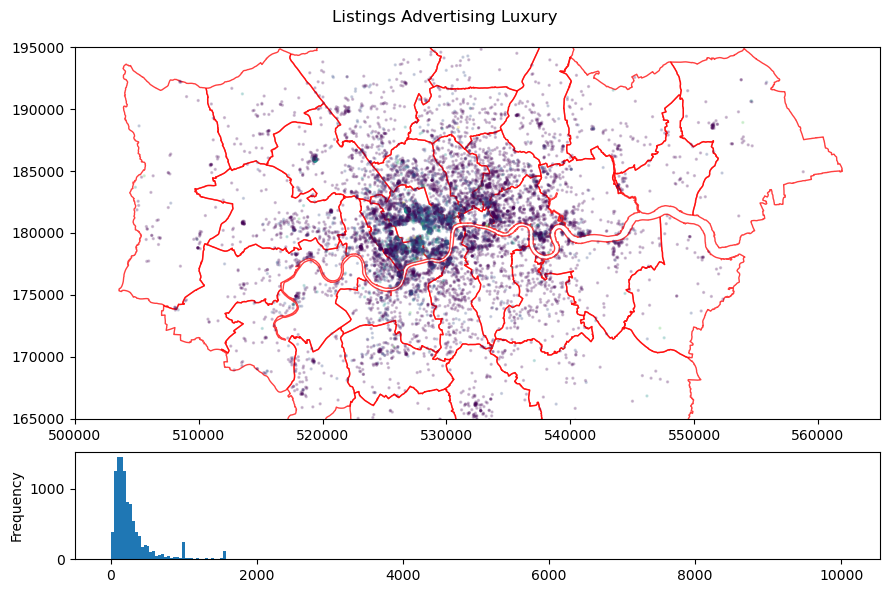

In [18]:

f,ax = plt.subplots(1,1,figsize=(9,6)) # 创建一个包含 1 行 1 列的图形和一个初始轴 ax
ax.remove()

# The first plot 
ax1 = plt.subplot2grid((4, 1), (0,0), rowspan=3) # 网格为 4 行 1 列，子图从 0 行 0 列开始，占据连续 3 行（图形高度占据 3/4）
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
lux.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4,1), (3,0), rowspan=1) # 子图从 3 行 0 列开始，占据 1 行（图形高度占据 1/4）
lux.price.plot.hist(bins=250, ax=ax2)

plt.suptitle("Listings Advertising Luxury") # <-- How does this differ from title? Change it and see!
plt.tight_layout() # <-- Try creating the plot *without* this to see what it changes
plt.show()

Your result should look similar to:

##### 3.1.3.2 Question

-   What does `suptitle` do and how is it different from `title`? Could
    you use this as part of your plot-making process?
-   What does `tight_layout` do?

### 3.2 Budget Listings

> **Difficulty level: Easy, because you’ve worked out the hard bits
> already.**

#### 3.2.1 Create the Regular Expression

What words can you think of that might help you to spot affordable and
budget accommodation? Start with just a couple of words and then I would
encourage you to consider what *other* words might help to signal
‘affordability’… perhaps words like ‘cosy’ or ‘charming’ and then think
about how you could you add those to the regex?

*Hints*: this just builds on what you did above with one exception:

1.  I’d try adding word boundary markers to the regex (`\b`) where
    appropriate…

##### 3.2.1.1 Question

In [20]:
gdf[
    gdf.description.str.contains(r'\b(affordable|budget|cheap|cosy)\b'
, regex=True, flags=re.IGNORECASE)   # \b 表示只匹配完整单词，如\bword 只匹配 word，而不匹配 sword
].sample(5, random_state=42)[['description']]

/tmp/ipykernel_162/2023548696.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  gdf.description.str.contains(r'\b(affordable|budget|cheap|cosy)\b'


,description
8635,"This is a charming little flat in crouch end, North London. It is located 10min from crouch end ""village"" which is packed with coffee shops, nice restaurants, shops etc... It is on a very quiet street and easy access to central London.<br /><br /..."
54551,"This trendy and spacious 3 bed house in Bow, is ideal for people who want to experience London but without all the hustle and bustle.<br /><br />It is situated in a peaceful area, where the vast open space of Victoria Park is within easy reach an..."
5904,"The spacious house offers double bedroom with ensuit bathroom, a large kitchen and cosy living room.<br />This luxurious and modern apartment is located 3 mins walking from London Bridge station; walking distance from many of Londons attractions<..."
57422,"Kick back and relax in this calm, stylish one-bedroom, ground-floor flat in Leyton Village. There’s a contemporary kitchen and cosy living room with a sofa bed. The location puts you between Leyton and Leytonstone tube stations in a quiet street ..."
58061,"Beautiful 1 bedroom apartment in the heart of Peckham, only 10 minutes walk away from Peckham Rye station with direct trains to London Victoria (15mins), London Bridge (10mins) and Clapham Junction (16mins) - bringing the whole of London to your ..."


#### 3.2.2 Apply it to Select Data

##### 3.2.2.1 Question

In [21]:
aff = gdf[gdf.description.str.contains(r'\b(affordable|budget|cheap|cosy)\b'
, regex=True, flags=re.IGNORECASE)].copy()
aff.to_parquet(os.path.join('data','clean','affordable.geopackage'))
print(f"There are {aff.shape[0]:,} rows flagged as 'affordable'.")

/tmp/ipykernel_162/769478959.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  aff = gdf[gdf.description.str.contains(r'\b(affordable|budget|cheap|cosy)\b'


There are 8,937 rows flagged as 'affordable'.


You should get that there are `8,937` rows.

#### 3.2.3 Plot the Data

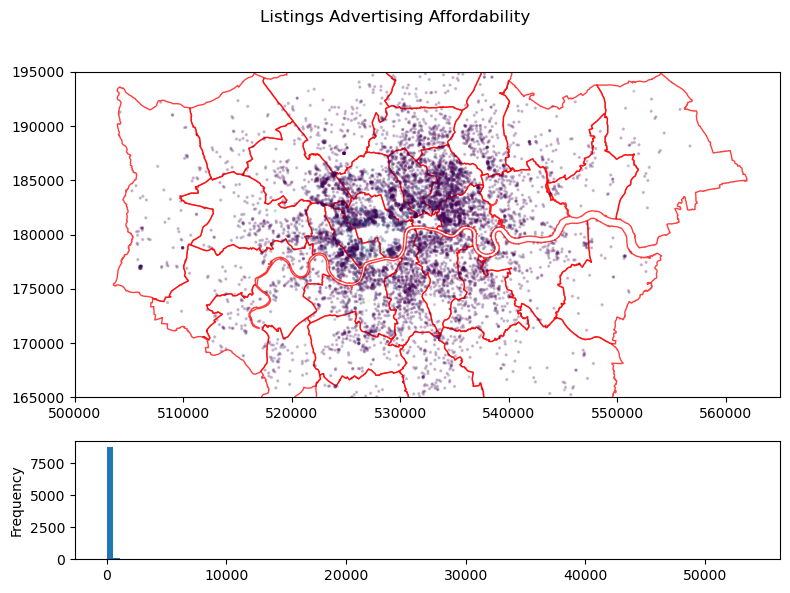

In [22]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.remove()

# The first plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
aff.plot(markersize=2, column='price', cmap='viridis', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
aff.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Listings Advertising Affordability")
plt.tight_layout()
#plt.savefig("Affordable_Listings.png", dpi=150)

#### 3.2.4 Questions

-   Do you think that this is a *good* way to select affordable options?
-   Do you understand what `dpi` means and how `savefig` works?
-   Copy the code from above but modify it to constrain the histogram on
    a more limited distribution by *filtering* out the outliers *before*
    drawing the plot. I would copy the cell above to one just below here
    so that you keep a working copy available and can undo any changes
    that break things.

``` python

```

### 3.3 Near Bluespace

> **Difficulty level: Medium, because you’re still learning about
> regexes.**

Now see if you can work out a regular expression to find accommodation
that emphasises accessibility to the Thames and other ‘blue spaces’ as
part of the description? One thing you’ll need to tackle is that some
listings seem to say something about Thameslink and you wouldn’t want
those be returned as part of a regex looking for *rivers*. So by way of
a hint:

-   You probably need to think about the Thames, rivers, and water.
-   These will probably be *followed* by a qualifier like a ‘view’
    (e.g. Thames-view) or a front (e.g. water-front).
-   But you need to rule out things like “close the Thameslink station…”

#### 3.3.1 Create the regular Expression

##### 3.3.1.1 Question

In [23]:
# ?: 表示非捕获组，帮助处理匹配逻辑，但不会保存结果
# canals 通过 s? 匹配单数和复数形式，? 表示可选
# (?:-|\s+)匹配关键词与后缀之间的连接方式，包括 - 匹配连接符和 \s+：匹配一个或多个空格
# 匹配 "view" 前面有一个空格，匹配 "front" 前可能有 0 或 1 个空格
# \b 防止匹配到如 Thameslink 之类
gdf[
    gdf.description.str.contains(r'(?:Thames|river|water|canals?)(?:-|\s+)(?: view|\s?front)\b',  regex=True, flags=re.IGNORECASE)
].sample(5, random_state=42)[['description']]

,description
74134,"Brand new ultra spacious apartment just one minute walk from the Excel center and with great connections to anywhere in London.<br />The area is full with cafés, supermarkets and restaurants just at your door step with lots of fun things to do li..."
49557,"Are you a woman?<br />We offer a warm and friendly, Home from home, welcome to women travellers in our, peaceful and centrally located home.<br /><br /> Excellent location in Zone1, with river ferry, trains, tube, and buses within a 5 minute wal..."
69318,"Just across the street from water front, near shadwell basin. View of Canary Wharf and the Shard on the big balcony<br /><br />7mins to shadwell overground and DLR. just 1 stop from Bank, Tower Bridge/Tower Hill, White Chapel (which connects to E..."
57420,There’s no better way to experience the beauty of London City than by sleeping right in the heart of it. This Ensuite is within a 2-bed property. Ideally located at the river front to enjoy the mesmerising view of Canary Wharf.<br /><br />Within ...
25666,"Welcome to Sunbury Lane in Battersea :)<br /><br />My house is just off the river front allowing a large, safe space from which to explore the best of South London whilst also having a bus that runs you from our road into central in just 15 minut..."


#### 3.3.2 Apply it to the Select Data

##### 3.3.2.1 Question

In [24]:
bluesp = gdf[
    (gdf.description.str.contains(r'(?:Thames|river|water|canals?)(?:-|\s+)(?:view|front)\b'
, regex=True, flags=re.IGNORECASE)) |
    (gdf.description.str.contains(r'(?:walk|close|near) to (?:Thames|river|water|canal)'
, regex=True, flags=re.IGNORECASE))
].copy()
bluesp.to_parquet(os.path.join('data','clean','bluespace.geopackage'))
print(f"Found {bluesp.shape[0]:,} rows.")

Found 408 rows.


You should get that there are `408` rows.

#### 3.3.3 Plot the Data

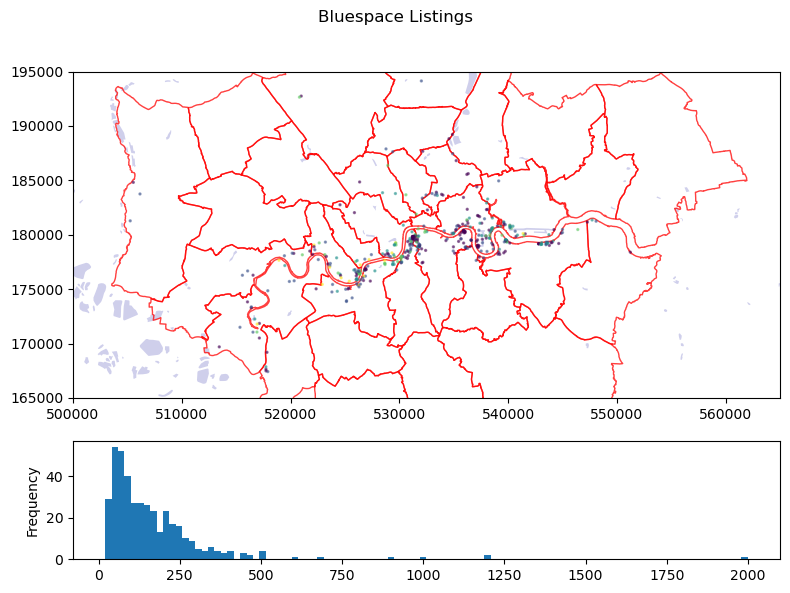

In [25]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.remove()

# The first plot
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
water.plot(edgecolor='none', facecolor=(.25, .25, .7, .25), ax=ax1)
boros.plot(edgecolor='red', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
bluesp.plot(markersize=2, column='price', cmap='viridis', alpha=0.5, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The second plot
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
bluesp.price.plot.hist(bins=100, ax=ax2)

plt.suptitle("Bluespace Listings")
plt.tight_layout()
plt.show()

#### 3.3.4 Questions

-   How else might you select listings with a view of the Thames or
    other bluespaces?

### 3.4 Resources

There is a lot more information out there, including a [whole
book](https://www.nltk.org/book/) and your standard [O’Reilly
text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:

-   [Pandas String Contains
    Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
-   [Using Regular Expressions with
    Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
-   [Summarising Chapters from Frankenstein using
    TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)